# SNLP Assignment 9

Name 1: Entang Wang<br>
Student id 1: 7069521<br>
Email 1: enwa00001@stud.uni-saarland.de<br>

Name 2: Zichao Wei<br>
Student id 2: 7063941<br>
Email 2: ziwe00001@stud.uni-saarland.de<br>

Name 3: Xiao Wang<br>
Student id 3: 7039023<br>
Email 3: xiwa00004@stud.uni-saarland.de<br>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook. There is no need to submit the data files. <br/>
Upload the zipped folder on CMS. Please follow the naming convention of **Name1_studentID1_Name2_studentID2_Name3_studentID3.zip**. Make sure to click on "Turn-in" (or the equivalent on CMS) after you upload your submission, otherwise the assignment will not be considered as submitted. Only one member of the group should make the submisssion.

---

In [ ]:
!pip install -q transformers datasets sklearn-crfsuite seqeval

## Ex 9.3: Transformers and CRFs  

In this exercise, you will enhance a Transformer-based Named Entity Recognition (NER) model by adding a Conditional Random Field (CRF) layer on top of it. The goal is to compare a baseline Transformer model with a hybrid Transformer+CRF model on a subset of the CoNLL-2003 dataset, which you will load using Hugging Face datasets.

The baseline model uses a Transformer’s built-in token classification head, while the hybrid model extracts embeddings from the Transformer and feeds them into a separate CRF model for prediction.

The dataset loading and model initialization code is already provided.                  [**Total**: 5 points]

Your task is to complete the following functions:

- `get_transformer_predictions()`: Make NER predictions using a Transformer’s classification head. (0.5 points)

- `get_transformer_embeddings()`: Extract token embeddings from a pre-trained Transformer. (0.5 points)

- `embeddings_to_features()`: Convert token embeddings into CRF-compatible feature dictionaries. (0.5 points)

- `train_crf_model()`: Train a CRF using sklearn-crfsuite. (0.5 points)

- `evaluate_predictions()`: Evaluate predictions using F1 score and classification report. (0.5 points)

- `plot_per_label_f1()`: Plot the per-label F1 scores as a horizontal bar chart. (0.5 points)

- `plot_confusion_matrix()` : Plot the confusion matrix of predicted vs. true tags. (0.5 points)

Your goal is to compare the performance of:

- A baseline model that uses only the Transformer’s classification head.

- A hybrid model that feeds Transformer embeddings into a CRF.

In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
import sklearn_crfsuite
from seqeval.metrics import f1_score
from sklearn_crfsuite import metrics
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load a small subset of the dataset
def load_conll_subset(train_size=500, test_size=100):
    """
    Load a small subset of the CoNLL-2003 dataset for quick testing.
    """
    train = load_dataset('eriktks/conll2003', split='train').select(range(train_size))
    test = load_dataset('eriktks/conll2003', split='validation').select(range(test_size))
    return train, test

# Load models and tokenizer
def load_models(model_checkpoint="distilbert-base-cased", num_labels=9):
    """
    Load the tokenizer and models for token classification and embeddings.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model_cls = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    model_embed = AutoModel.from_pretrained(model_checkpoint)
    return tokenizer, model_cls, model_embed

# Get label mapping
def get_label_mappings(train_dataset):
    """
    Get label mappings from the training dataset.
    """
    labels = train_dataset.features['ner_tags'].feature.names
    id2label = {i: label for i, label in enumerate(labels)}
    return labels, id2label


In [13]:
def get_transformer_predictions(dataset, tokenizer, model, id2label):
    """
    Generate NER predictions using the classification head of a pretrained Transformer model.

    Args:
        dataset (datasets.Dataset): A dataset of tokenized sequences with NER tags.
        tokenizer (PreTrainedTokenizer): HuggingFace tokenizer corresponding to the model.
        model (PreTrainedModel): Transformer model with a token classification head.
        id2label (dict): Mapping from tag ID to string label.

    Returns:
        tuple: A pair (true_labels, predicted_labels), where each is a list of token-level NER label sequences.
    """

    true_labels, pred_labels = [], []
    for example in dataset:
        tokens = example['tokens']
        labels = [id2label[i] for i in example['ner_tags']]
        # tokenization
        encoding = tokenizer(tokens, is_split_into_words=True, return_tensors='pt', truncation=True)
        outputs = model(**encoding)
        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        word_ids = encoding.word_ids()
        # align word_ids
        pred_seq, true_seq = [], []
        for idx, word_id in enumerate(word_ids):
            # skip special token
            if word_id is None:
                continue
            if idx == 0 or word_id != word_ids[idx-1]:
                pred_seq.append(id2label[predictions[idx]])
                true_seq.append(labels[word_id])
        true_labels.append(true_seq)
        pred_labels.append(pred_seq)
    return true_labels, pred_labels


def get_transformer_embeddings(dataset, tokenizer, model, id2label):
    """
    Extract last-layer hidden state embeddings from a Transformer model and align them to original tokens.

    Args:
        dataset (datasets.Dataset): A dataset of tokenized sequences with NER tags.
        tokenizer (PreTrainedTokenizer): HuggingFace tokenizer corresponding to the model.
        model (PreTrainedModel): Transformer model (without classification head) that outputs hidden states.
        id2label (dict): Mapping from tag ID to string label.

    Returns:
        tuple: A pair (all_embeddings, all_labels), where:
            - all_embeddings is a list of lists of token-level embedding vectors (np.ndarray).
            - all_labels is a list of NER label sequences corresponding to each sentence.
    """
    all_embeddings, all_labels = [], []
    for example in dataset:
        tokens = example['tokens']
        labels = [id2label[i] for i in example['ner_tags']]
        encoding = tokenizer(tokens, is_split_into_words=True, return_tensors='pt', truncation=True)
        with torch.no_grad():
            outputs = model(**encoding, output_hidden_states=True)
        hidden_states = outputs.last_hidden_state.squeeze()  # Shape: (seq_len, hidden_dim)
        word_ids = encoding.word_ids()
        sent_embs, sent_labels = [], []
        for idx, word_id in enumerate(word_ids):
            # skip special token
            if word_id is None:
                continue
            # record embedding at the first sub-token
            if idx == 0 or word_id != word_ids[idx-1]:
                sent_embs.append(hidden_states[idx].cpu().numpy())
                sent_labels.append(labels[word_id])
        all_embeddings.append(sent_embs)
        all_labels.append(sent_labels)
    return all_embeddings, all_labels


def embeddings_to_features(sentence_embeddings):
    """
    Convert embeddings to CRF features
    """
    features = []
    for emb in sentence_embeddings:
        feature = {f'emb_{i}': float(val) for i, val in enumerate(emb)}
        features.append(feature)
    return features


def train_crf_model(X_train, y_train):
    """
    Train a linear-chain CRF using token-level feature dictionaries.

    Args:
        X_train (List[List[dict]]): List of token-level feature sequences (sentences).
        y_train (List[List[str]]): List of corresponding label sequences.

    Returns:
        sklearn_crfsuite.CRF: A trained CRF model.
    """
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1, c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)
    return crf


def evaluate_predictions(true, pred, model_name="Model"):
    """
    Compute and print the F1 score for sequence labeling predictions.

    Args:
        true (List[List[str]]): Ground truth token label sequences.
        pred (List[List[str]]): Predicted token label sequences.
        model_name (str): Name of the model for display purposes.

    Returns:
        float: The micro-averaged F1 score.
    """
    f1 = f1_score(true, pred)
    return f1

def plot_per_label_f1(true, pred, title="Model"):
    """
    Plot a horizontal bar chart of per-label F1 scores.

    Args:
        true (List[List[str]]): Ground truth token label sequences.
        pred (List[List[str]]): Predicted token label sequences.
        title (str): Title to prefix the plot with (typically the model name).
    """
    from sklearn.metrics import precision_recall_fscore_support
    y_true = [label for seq in true for label in seq]
    y_pred = [label for seq in pred for label in seq]
    labels = sorted(set(y_true))
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, average=None, zero_division=0)
    plt.figure()
    plt.barh(range(len(labels)), f)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('F1 Score')
    plt.title(f'{title} F1 Score')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true, pred, labels, title="Model"):
    """
    Plot a confusion matrix for NER predictions.

    Args:
        true (List[List[str]]): Ground truth token label sequences.
        pred (List[List[str]]): Predicted token label sequences.
        labels (List[str]): List of all possible labels in a consistent order.
        title (str): Title to prefix the plot with (typically the model name).
    """
    from sklearn.metrics import confusion_matrix
    y_true = [label for seq in true for label in seq]
    y_pred = [label for seq in pred for label in seq]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'{title} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

In [6]:
print("Loading data and models...")
train_data, test_data = load_conll_subset()
tokenizer, model_cls, model_embed = load_models()
labels, id2label = get_label_mappings(train_data)

print("\n--- Running Baseline (Transformer-Only) Experiment ---")
baseline_true, baseline_pred = get_transformer_predictions(test_data, tokenizer, model_cls, id2label)
baseline_f1 = evaluate_predictions(baseline_true, baseline_pred, model_name="Transformer Only")

print("\n--- Running Transformer + CRF Experiment ---")
train_embs, y_train = get_transformer_embeddings(train_data, tokenizer, model_embed, id2label)
test_embs, y_test = get_transformer_embeddings(test_data, tokenizer, model_embed, id2label)

X_train = [embeddings_to_features(e) for e in train_embs]
X_test = [embeddings_to_features(e) for e in test_embs]

crf_model = train_crf_model(X_train, y_train)
y_pred_crf = crf_model.predict(X_test)

crf_f1 = evaluate_predictions(y_test, y_pred_crf, model_name="Transformer + CRF")

print("\n" + "="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)
print(f"Transformer Only F1 Score:     {baseline_f1:.4f}")
print(f"Transformer + CRF F1 Score:    {crf_f1:.4f}")
print("="*50)

Loading data and models...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Running Baseline (Transformer-Only) Experiment ---

--- Running Transformer + CRF Experiment ---

FINAL RESULTS COMPARISON
Transformer Only F1 Score:     0.0359
Transformer + CRF F1 Score:    0.7460


Confusion Matrices


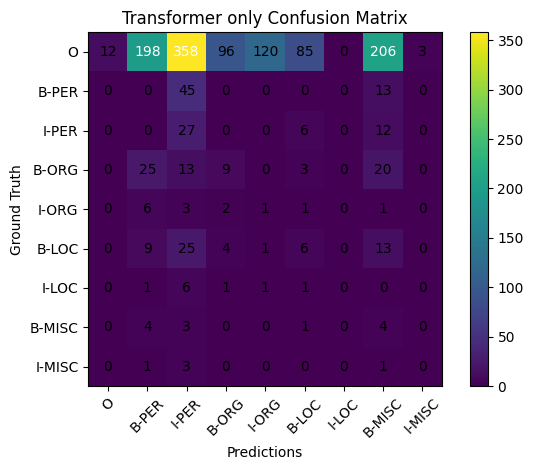

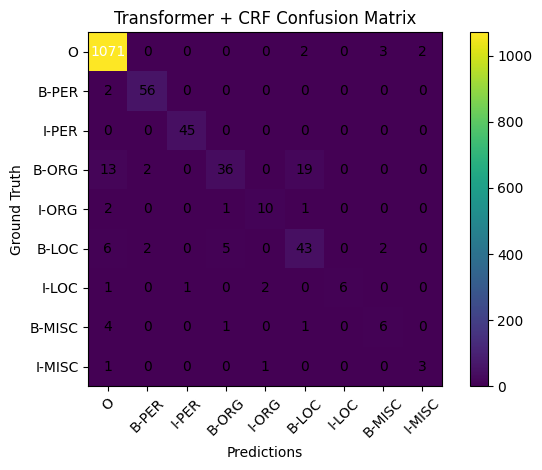

In [9]:
print("Confusion Matrices")
plot_confusion_matrix(baseline_true, baseline_pred,labels=labels, title="Transformer only")
plot_confusion_matrix(y_test, y_pred_crf, labels=labels, title="Transformer + CRF")

Per label F1-scrore


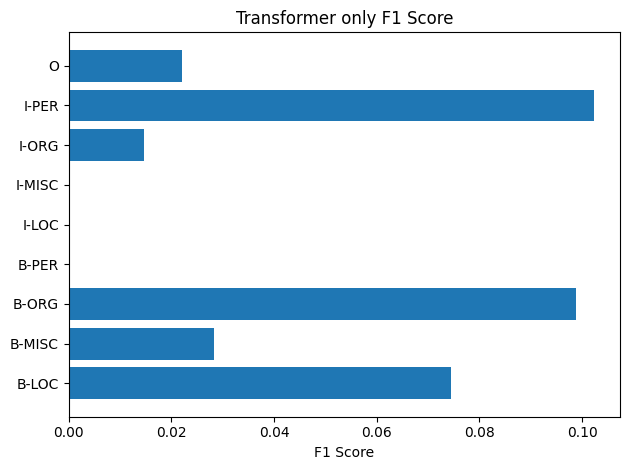

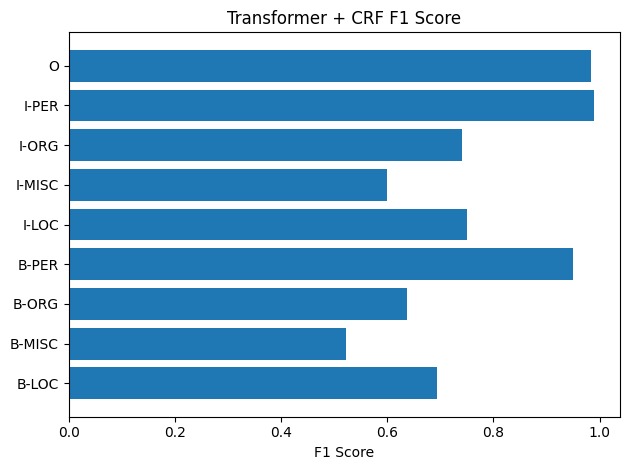

In [14]:
print("Per label F1-scrore")
plot_per_label_f1(baseline_true, baseline_pred, title="Transformer only")
plot_per_label_f1(y_test, y_pred_crf, title="Transformer + CRF")


Answer the following questions:

1. Explain your results. Why do you think a CRF might be more effective than a simple classification head in certain NER tasks? **(0.25 points)**

2. Under what circumstances might the CRF layer not improve performance over the baseline Transformer model?  **(0.25 points)**

3. In what way does a CRF impose **global sequence-level constraints**, and how does this affect prediction quality?  **(0.25 points)**

4. What properties of Transformer embeddings make them well-suited (or not) for CRF-based modeling, as compared to LSTMs, for example? **(0.25 points)**

5. Do you think you could use this pipeline for domain adaptation (e.g., transferring NER from news articles to scientific literature)?  **(0.25 points)**

6. Why do you think we are using F1-score as a metric here? **(0.25 points)**

Answer:

1. A simple token-classification head predicts each label independently given its local context embedding. It has no mechanism to enforce valid tag transitions (e.g., B-ORG → I-ORG) and can suffer from inconsistent label sequences. A CRF layer, by contrast, learns transition scores between tags and decodes the entire sequence jointly, favoring globally coherent tag paths.

2.
* Very large training data: With enough examples, a Transformer's classifier can implicitly learn valid transitions, reducing the marginal gain from a CRF.

* Simple label sets: If the task has only two classes (e.g., “entity” vs. “non-entity”) or no strict transition rules, the overhead of CRF may not pay off.

* Noisy or inconsistent annotations: When label noise breaks the transition assumptions, enforcing global constraints can actually harm recall.

3. A linear-chain CRF introduces a learnable matrix of transition scores between every pair of tags. During inference, it finds the sequence of labels whose sum of per-token emission (from the Transformer) plus transition scores is maximized. By optimizing over the whole sentence rather than each token independently, it can prevent illegal transitions (e.g. I-PER after O), smooth out isolated mistakes and prefer coherent spans.

4.
* Contextualization: Transformers produce contextual embeddings, and capture long-range dependencies more directly via self-attention.

* Rich feature space: Deep Transformers yield high-dimensional, semantically rich token vectors that can be linearly separated by the CRF's emission weights.

* Non-sequential computation: Transformers compute all token representations in parallel; the CRF then re-injects sequential structure via its transition matrix. This decoupling often results in faster training and stronger global modeling.

5. Yes. You can typically fine-tune the Transformer+CRF on a small annotated corpus from the target domain (scientific text). The CRF helps enforce consistent entity spans even if your target domain has different entity distributions. However, you may need to adjust the tag set (e.g., new entity types) and possibly further pre-train the Transformer on in-domain unlabeled text to align its embeddings better before CRF training.

6. NER is a highly imbalanced problem—most tokens are non-entities (O), and false positives/negatives in entity spans have asymmetric impact. The F1-score  balances these two aspects, ensuring that a model isn't trivially high-scoring by over-predicting one class.
